In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

np.random.seed(0)

In [2]:
from typing import List, Union, Dict

def MaxEigval(M : np.ndarray) -> np.float32:
        return np.max(np.abs(scipy.linalg.eigvalsh(M)))

def Hessian(X : np.ndarray) -> np.ndarray:
    return (X.T @ X) / X.shape[0]

class RidgeData:
    def FindRidgeOptimal(X : np.ndarray, y : np.ndarray, lam : float) -> np.ndarray:
        return np.linalg.inv(X.T @ X + (lam * X.shape[0]) * np.eye(X.shape[1])) @ X.T @ y
    
    def FindL(X : np.ndarray, lam : float) -> np.float32:
        return MaxEigval(Hessian(X)) + lam
    
    def EstimateAllL(xs : List[np.ndarray], lam : float) -> List[np.float32]:
        return [RidgeData.FindL(np.vstack(xs), lam)] + [RidgeData.FindL(X_i, lam) for X_i in xs]

    def EstimateL(xs : List[np.ndarray], lam : float) -> np.float32:
        return np.max(RidgeData.EstimateAllL(xs, lam))
    
    def EstimateLsum(xs : List[np.ndarray], lam : float) -> np.float32:
        return RidgeData.FindL(np.vstack(xs), lam) 
    
    def EstimateLq(xs : List[np.ndarray], lam : float) -> np.float32:
        return RidgeData.FindL(xs[0], lam)
    
    def EstimateLp(xs : List[np.ndarray], lam : float) -> np.float32:
        HessianP = np.mean([Hessian(X) for X in xs], axis=0) - Hessian(xs[0])
        return MaxEigval(HessianP)
    
    def EstimateDelta(xs : List[np.ndarray]) -> np.float32:
        Hessian_g = Hessian(xs[0])
        return np.max([MaxEigval(Hessian_g - Hessian(X_i)) for X_i in xs])

    def __init__(self, lam : float, num_workers : int, num_feat : int, cnt_worker_data : int, delta_mult : float):
        self.num_workers = num_workers
        self.num_feat = num_feat
        self.cnt_worker_data = cnt_worker_data
        self.lam = lam

        self.ys = []
        self.xs = []
        w = np.random.normal(size=(num_feat, 1))
        
        for i in range(num_workers):
            if i == 0:
                x = np.random.normal(size=(cnt_worker_data, num_feat))
                self.xs.append(x)
                self.ys.append(x @ w + np.random.normal(size=(cnt_worker_data, 1)))
            else:
                x = self.xs[0] + np.random.normal(size=(cnt_worker_data, num_feat)) * delta_mult
                self.xs.append(x)
                self.ys.append(x @ w + np.random.normal(size=(cnt_worker_data, 1)))
            
        self.w_star = RidgeData.FindRidgeOptimal(X = np.vstack(self.xs), y = np.vstack(self.ys), lam=lam)
        self.L = RidgeData.EstimateLsum(xs=self.xs, lam=lam)
        self.Lp = RidgeData.EstimateLp(xs=self.xs, lam=lam)
        self.Lq = RidgeData.EstimateLq(xs=self.xs, lam=lam)
        self.delta = RidgeData.EstimateDelta(xs=self.xs)
        self.mu = lam
    
    def __repr__(self) -> str:
        return "num_workers: {}; d: {}; cnt_worker_data: {};\ndelta: {}; L: {}; Lp: {}; Lq: {}; mu: {};".format(
                self.num_workers, self.num_feat, self.cnt_worker_data, self.delta, self.L, self.Lp, self.Lq, self.mu
                )

    def Loss(self, w : np.ndarray) -> np.float32:
        X = np.vstack(self.xs)
        y = np.vstack(self.ys)
        return 1 / (2 * X.shape[0]) * (np.linalg.norm(X @ w - y) ** 2) + 1 / (2 * self.lam) * (np.linalg.norm(w) ** 2)
    
    def Error(self, w : np.ndarray) -> np.float32:
        return np.linalg.norm(w - self.w_star) ** 2

In [3]:
from typing import List, Tuple
from abc import ABC, abstractmethod

class Optimizer(ABC):
    def __init__(self, data : RidgeData):
        self.communications = 0
        self.local_calls = 0 
        self.data = data

    def local_gradient(self, id : int, w : np.ndarray) -> np.ndarray:
        self.local_calls += 1
        X, y = self.data.xs[id], self.data.ys[id]
        return (1/self.data.cnt_worker_data) * (X.T @ X @ w - X.T @ y) + self.data.lam * w 
    
    def r_gradient(self, w : np.ndarray) -> np.ndarray:
        return np.mean([self.local_gradient(i, w) for i in range(self.data.num_workers)], axis=0)
    
    def p_gradient(self, w : np.ndarray) -> np.ndarray:
        gradient_1 = self.local_gradient(0, w)
        result = np.zeros(w.shape)
        n = self.data.num_workers
        for i in range(1, n):
            result += (1 / n) * (self.local_gradient(i, w) -  gradient_1)
        return result
    
    def q_gradient(self, w : np.ndarray) -> np.ndarray:
        return self.local_gradient(0, w)
    
    @abstractmethod
    def optimize(self, K : int = 100) -> Tuple[np.ndarray, List[int]]:
        """
            return : returns relaive errors, and list of number of local calls and corresponding 
        """
        ...


class DummyGradient(Optimizer):
    def optimize(self, K: int = 100) -> Tuple[np.ndarray]:
        
        eta = 1 / self.data.L
        w = np.zeros(shape=(self.data.num_feat, 1))
        start_err = self.data.Error(w)
        rel_errs = []
        local_calls = []

        for k in range(K):
            w = w - eta * self.r_gradient(w)
            rel_errs.append(self.data.Error(w) / start_err)
            local_calls.append(self.local_calls)
        return rel_errs, local_calls


class AcGD(Optimizer):
    def optimize(self, K: int = 100) -> Tuple[np.ndarray, List[int]]:

        y = w = np.zeros(shape=(self.data.num_feat, 1))
        kappa = self.data.L / self.data.mu
        coef = (np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1)
        start_err = self.data.Error(w)
        rel_errs = []
        local_calls = []

        for k in range(K):
            y_prev = y
            y = w - (1 / self.data.L) * self.r_gradient(w)
            w = (1 + coef) * y - coef * y_prev
            rel_errs.append(self.data.Error(w) / start_err)
            local_calls.append(self.local_calls)

        return rel_errs, local_calls
   
class AccExtra(Optimizer):

    def solve_subproblem(self, x_g):
        
        y = x_f = x_g
        theta = 1 / (2 * self.data.Lp)
        L = 2 * self.data.Lp + self.data.Lq
        mu = 1 / theta
        grad_p_x_g = self.p_gradient(x_g)
        grad_A_x_f = lambda x : grad_p_x_g + (1 / theta) * (x - x_g) + self.q_gradient(x)
        
        prev_norm = None

        kappa = L / mu

        coef = 0 * (np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1)

        tol = 1e-12
        while True:
            
            grad = grad_A_x_f(x_f)
            norm = np.linalg.norm(grad)
            if norm <= self.data.Lp * np.linalg.norm(x_f - x_g):
                return x_f
            if prev_norm is not None and prev_norm - norm <= tol:
                return x_f
            prev_norm = norm

            y_prev = y
            y = x_f - (1 / L) * grad
            x_f = (1 + coef) * y - coef * y_prev
        
    def optimize(self, K : int = 100) -> Tuple[np.ndarray, List[int]]:
        
        tau = min(1, np.sqrt(self.data.mu) / (2 * np.sqrt(self.data.Lp)))
        eta = min(1 / (2 * self.data.mu), 1 / (2 * np.sqrt(self.data.mu * self.data.Lp)))
        alpha = self.data.mu
        
        x = x_f = np.zeros(shape=(self.data.num_feat, 1))
        start_err = self.data.Error(x)
        rel_errs = []
        local_calls = []

        for k in range(K):
            x_g = tau * x + (1 - tau) * x_f
            x_f = self.solve_subproblem(x_g)
            x = x + eta * alpha * (x_f - x) - eta * self.r_gradient(x_f)
            rel_errs.append(self.data.Error(x) / start_err)
            local_calls.append(self.local_calls)
            
        return rel_errs, local_calls



class AccExtraDefault(Optimizer):
    def optimize(self, K : int = 100) -> Tuple[np.ndarray, List[int]]:
        
        theta = 1 / (2 * self.data.Lp)
        
        def ApproxAmin(x_g):
            x_f = x_g
            eta = 1 / (2 * self.data.Lp + self.data.Lq)
            grad_p_xg = self.p_gradient(x_g)

            
            tol = 1e-18
            prev = None
            while True:
                grad_a_xf = grad_p_xg + (x_f - x_g) / theta + self.q_gradient(x_f)
                grad_norm = np.linalg.norm(grad_a_xf)
                if (prev is not None and prev - grad_norm < tol):
                    return x_f
                prev = grad_norm
        
                x_f = x_f - eta * grad_a_xf
        
        tau = min(1, np.sqrt(self.data.mu) / (2 * np.sqrt(self.data.Lp)))
        eta = min(1 / (2 * self.data.mu), 1 / (2 * np.sqrt(self.data.mu * self.data.Lp)))
        alpha = self.data.mu
        
        x = x_f = np.zeros(shape=(self.data.num_feat, 1))
        start_err = self.data.Error(x)
        rel_errs = []
        local_calls = []

        for k in range(K):
            x_g = tau * x + (1 - tau) * x_f
            x_f = ApproxAmin(x_g)
            x = x + eta * alpha * (x_f - x) - eta * self.r_gradient(x_f)
            rel_errs.append(self.data.Error(x) / start_err)
            local_calls.append(self.local_calls)
            
        return rel_errs, local_calls
    

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 12
mpl.rcParams['grid.color'] = 'gray'
mpl.rcParams['grid.linestyle'] = '--'

def plot_errs(method_dicts : Dict[str, Tuple[np.ndarray, List[int]]], tol = 1e-8):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for name, values in method_dicts.items():
        errors, calls = values
        for k in range(len(errors)):
            if errors[k] < tol:
                errors = errors[:k + 1]
                calls = calls[:k + 1]
                break
        ax1.plot(errors, label=name)
        ax2.plot(calls, errors, label=name)

    
    fig.supylabel('$||w^{n} - w^*||^2 / ||w^0 - w^*||^2$')
    for ax, title in zip((ax1, ax2), ("Communications, N", "Local calls, N")):
        ax.set_xlabel(title)
        ax.set_yscale('log')
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')
    plt.show()

In [5]:
def MakeExperiment():
    methods = {"Default gradient" : DummyGradient,
               "AcGD" : AcGD,
               "Accelerated Extragradient" : AccExtra,
               "Default ACEG" : AccExtraDefault
               }
    data = RidgeData(0.1, num_feat=20, num_workers=50, cnt_worker_data=100, delta_mult=0.1)
    print(data)
    plot_errs({key : method(data=data).optimize() for key, method in methods.items()}, tol=1e-12)

num_workers: 50; d: 20; cnt_worker_data: 100;
delta: 0.16022239843257519; L: 1.9011597146845378; Lp: 0.027038870077002085; Lq: 1.8911664775669146; mu: 0.1;


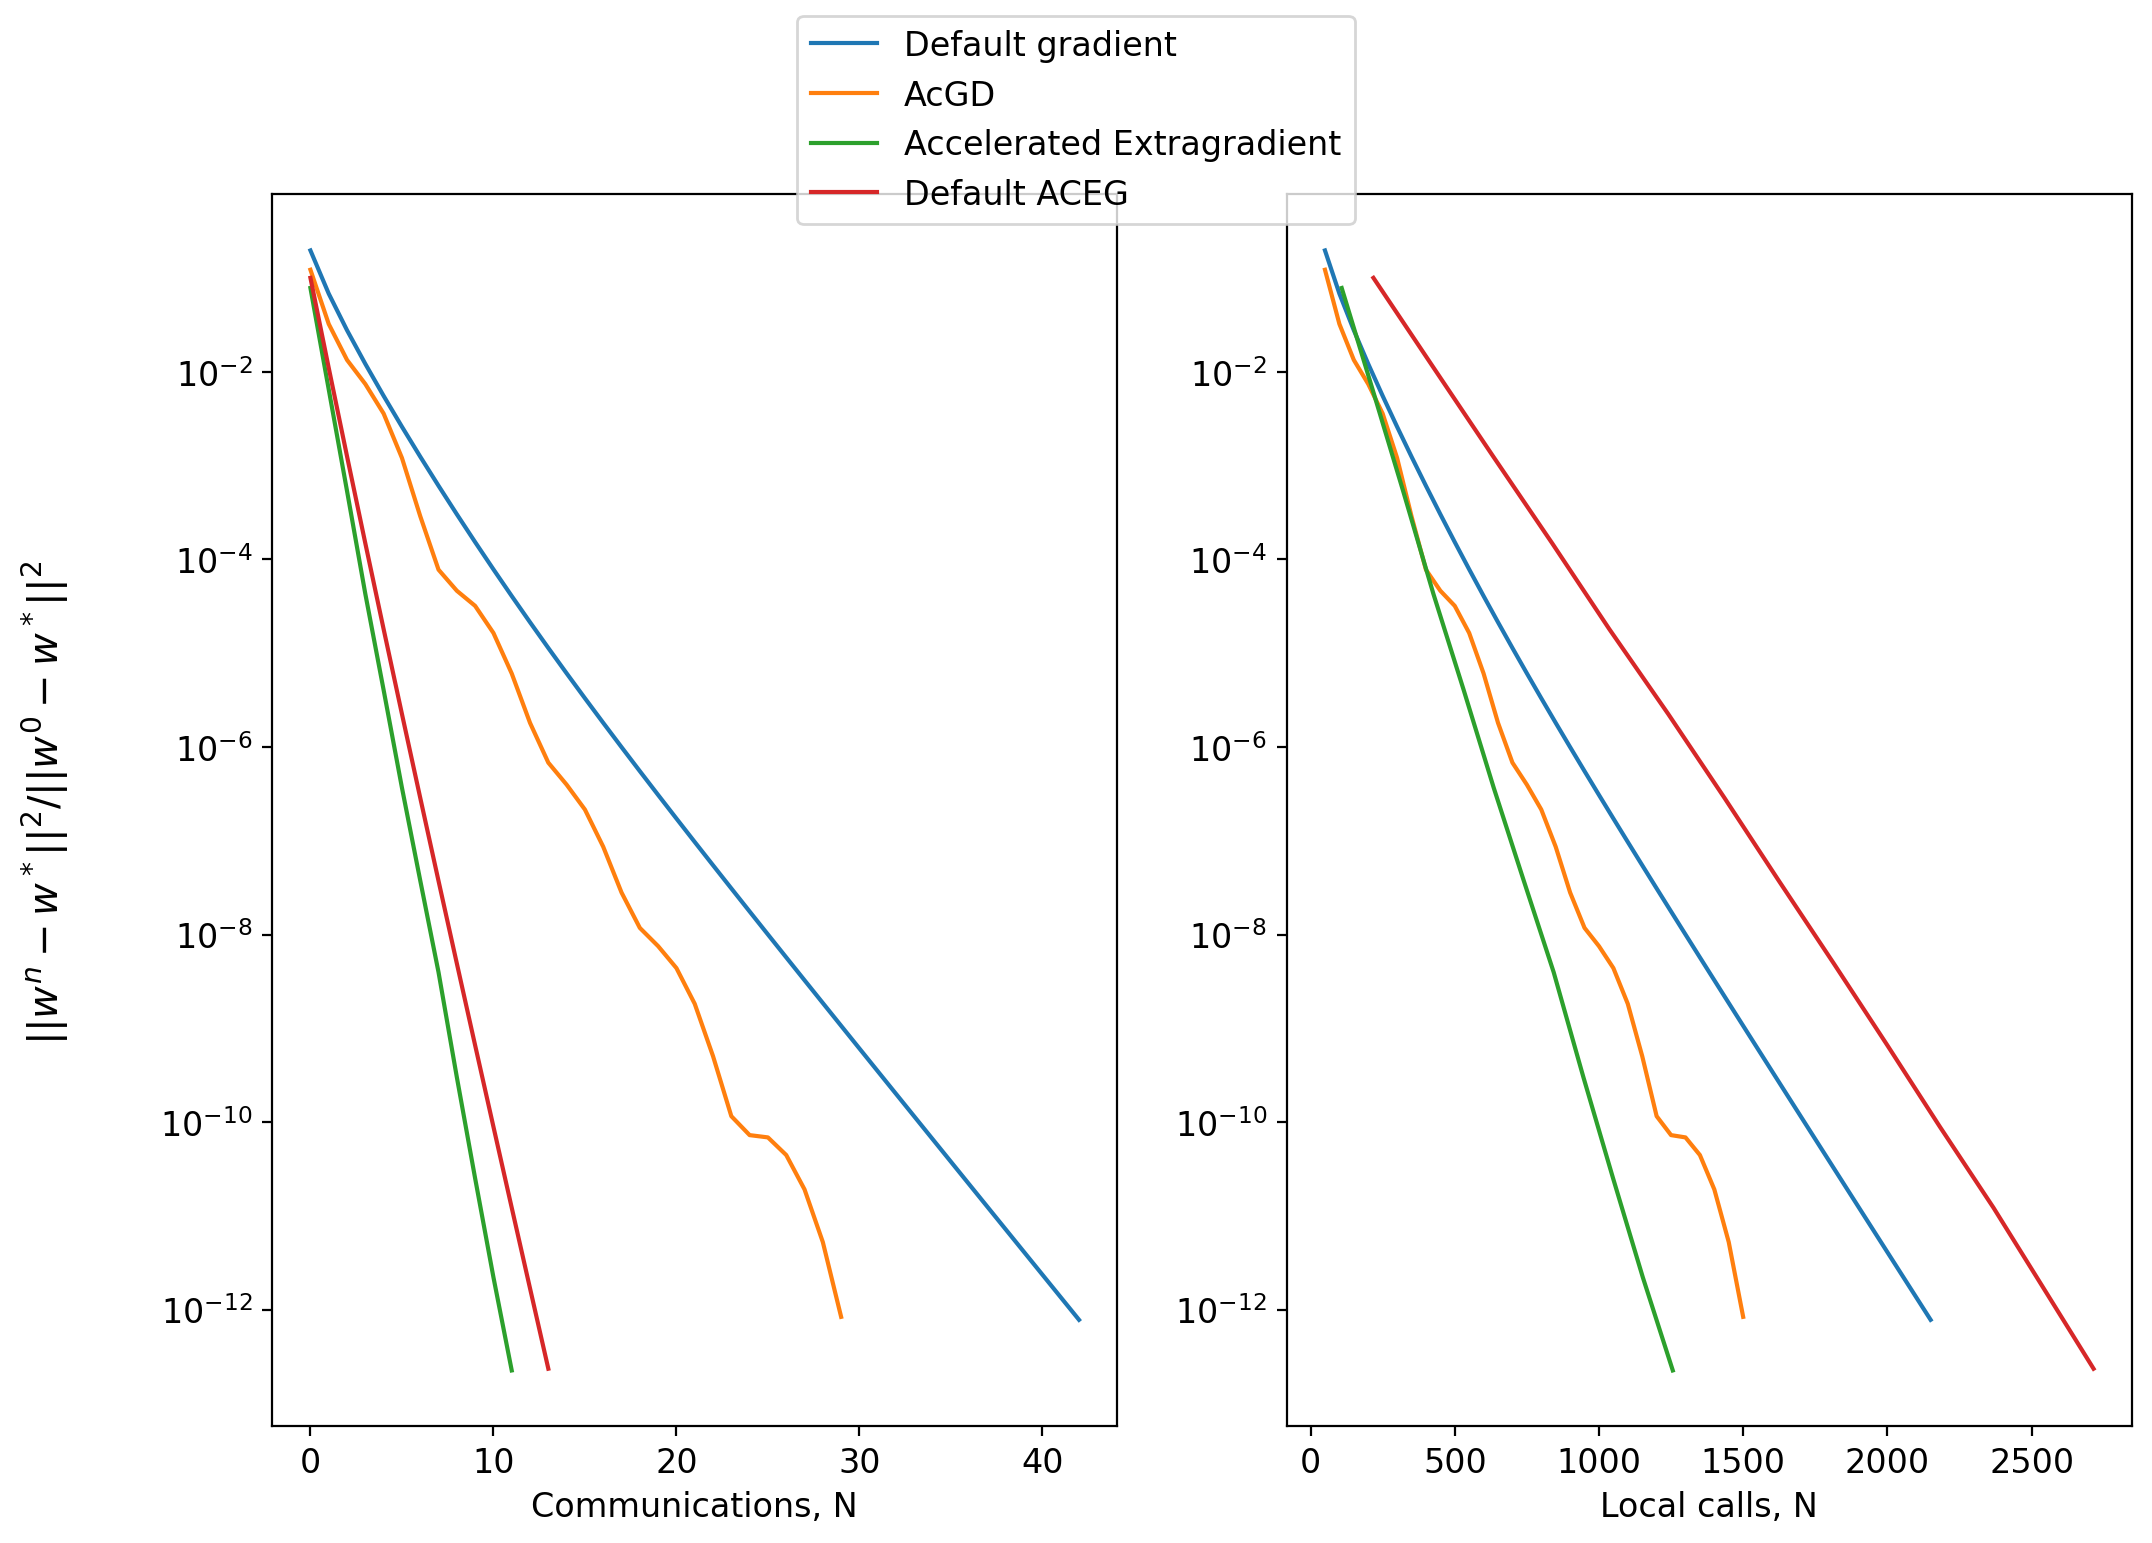

In [6]:
MakeExperiment()